In [1]:
import geopandas as gpd
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
import rasterio as ras
import numpy as np
import gc

In [2]:
data = gpd.read_file("Slides.geojson")

In [3]:
def readElev(filename):
    with ras.open(f"elev/{filename}") as file:
        zelev = file.read()
    return zelev
    
elev_std_1 = readElev("30n120w_20101117_gmted_std300.tif")[0]
elev_std_2 = readElev("30n150w_20101117_gmted_std300.tif")[0]

elev_1 = readElev("30n120w_20101117_gmted_med300.tif")[0]
elev_2 = readElev("30n150w_20101117_gmted_med300.tif")[0]

elev_stdg = np.hstack([elev_std_2, elev_std_1])
elevg = np.hstack([elev_2, elev_1])
del elev_1, elev_2, elev_std_1, elev_std_2

In [4]:
lonmin = -150
lonmax = -90
latmin = 30
latmax = 50
arcsecs = 30

In [5]:
(360 * 60 * 60) // 30

43200

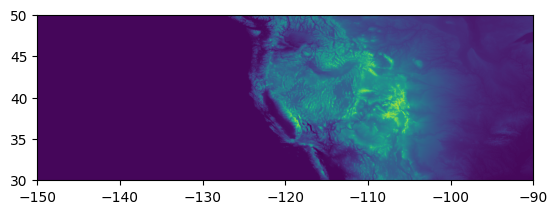

In [6]:
plt.imshow(elevg, extent=[lonmin, lonmax, latmin, latmax])

In [10]:
xidx = np.repeat(np.arange(0, elevg.shape[0])[::-1, None], elevg.shape[1], axis=1)
yidx = np.repeat(np.arange(0, elevg.shape[1])[None, :], elevg.shape[0], axis=0)

In [11]:
elev = elevg.flatten()
elev_std = elev_stdg.flatten()

lat = latmin + (xidx.flatten() / np.max(xidx.flatten() + 1)) * (latmax - latmin)
lon = lonmin + (yidx.flatten() / np.max(yidx.flatten() + 1)) * (lonmax - lonmin)

gc.collect()

1581

In [201]:
edata = gpd.GeoDataFrame(np.array([elev, elev_std]).T, geometry=gpd.points_from_xy(lon, lat, crs="EPSG:4326"), columns=["elev", "elev_std"])

In [202]:
counties = gpd.read_file("oregon.geojson").to_crs("EPSG:4326")
counties = counties[counties["COBCODE"].str.contains("OR")]

<Axes: >

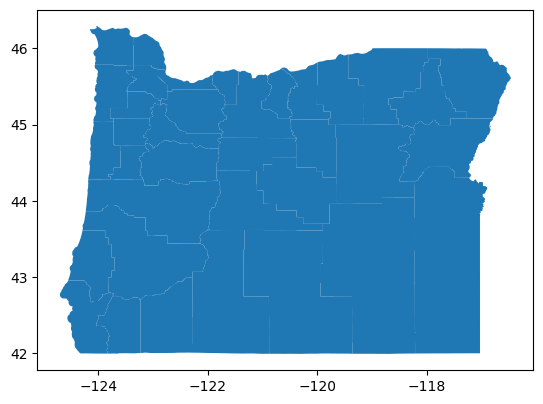

In [203]:
counties.plot()

In [204]:
edatasubset = counties.union_all(method="coverage").contains(edata.geometry)

In [205]:
edata = edata[edatasubset]
gc.collect()

273

In [218]:
edata.to_file("elev.geojson", driver="GeoJSON")

In [219]:
counties.to_file("orCounties.geojson", driver="GeoJSON")

In [14]:
data["YEAR"].isna().sum()

np.int64(7786)

In [16]:
(data["YEAR"] == 0).sum()

np.int64(368)

In [221]:
knownTime = data[(data["YEAR"] != 0) & (~data["YEAR"].isna())]

In [224]:
knownTime.to_file("landslidesKnownTime.geojson", driver="GeoJSON")

Text(0.5, 1.0, 'Oregon Landslides w/ Time info')

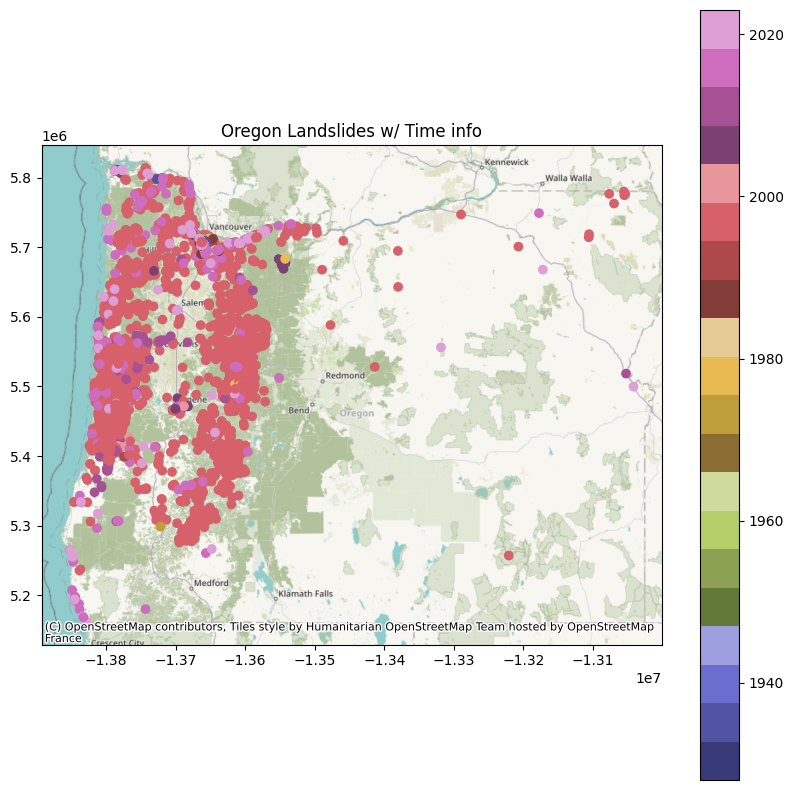

In [37]:
ax = knownTime.plot(figsize=(10, 10), column="YEAR", cmap="tab20b", legend=True)
cx.add_basemap(ax)
plt.title("Oregon Landslides w/ Time info")

In [43]:
knownTime.keys()

Index(['OBJECTID', 'REF_ID_COD', 'UNIQUE_ID', 'DATA_SOURC', 'LOC_METHOD',
       'ORIG_ID', 'SLIDE_NAME', 'LENGTH_ft', 'WIDTH_ft', 'DEPTH_ft', 'SLOPE',
       'TYPE_MOVE', 'MOVE_CLASS', 'CONTR_FACT', 'TYPE_MTRL', 'AREA_ft2',
       'VOLUME_ft3', 'DEEP_SHAL', 'DAMAGES', 'LOSSES', 'COMMENTS',
       'ANNUAL_COST', 'REPAIR_COST', 'YEAR', 'DATE_RANGE', 'REACTIVATION',
       'MONTH', 'DAY', 'geometry'],
      dtype='object')

In [54]:
features = ["SLOPE", "YEAR", "geometry"]
knownTime["SLOPE"]

1785     15.0
1786     30.0
1787     40.0
1788     55.0
1789     35.0
         ... 
15239     NaN
15241     NaN
15364     NaN
15365     NaN
15366     NaN
Name: SLOPE, Length: 7232, dtype: float64

In [56]:
counties

,OBJECTID,COUNTY_NAME,COBCODE,ORIG_FID,geometry
0,1,JOSEPHINE,OR033,75,"POLYGON ((-123.71649 42.78287, -123.71651 42.7..."
1,2,CURRY,OR015,74,"POLYGON ((-124.39041 42.95522, -124.3855 42.95..."
2,3,JACKSON,OR029,73,"POLYGON ((-122.37635 42.99663, -122.37143 42.9..."
3,4,COOS,OR011,72,"POLYGON ((-124.18132 43.61145, -124.18083 43.6..."
4,5,KLAMATH,OR035,71,"POLYGON ((-121.47141 43.61666, -121.46647 43.6..."
...,...,...,...,...,...
70,71,FERRY,WA019,5,"POLYGON ((-118.42286 49.00007, -118.38971 49.0..."
71,72,PEND OREILLE,WA051,4,"POLYGON ((-117.42919 49.00046, -117.39095 49.0..."
72,73,OKANOGAN,WA047,3,"POLYGON ((-120.55173 49.00056, -120.52491 49.0..."
73,74,STEVENS,WA065,2,"POLYGON ((-117.58026 49.0007, -117.50846 49.00..."
